In [1]:
%matplotlib inline

Adapted from:
* https://github.com/miykael/workshop_pybrain/ 
* https://nilearn.github.io/auto_examples/07_advanced/plot_bids_analysis.html
* https://nilearn.github.io/auto_examples/07_advanced/plot_bids_analysis.html

# Nilearn GLM: statistical analyses of MRI in Python


`Nilearn`'s `GLM/stats` module allows fast and easy MRI statistical analysis.

It leverages `Nibabel` and other Python libraries from the Python scientific stack like `Scipy`, `Numpy` and `Pandas`.

In this tutorial, we're going to explore `nilearn's GLM` functionality by analysing a sample dataset of language localiser task. We will analyse 1) a single subject data and 2) ten subject group level example using a General Linear Model (GLM).  

## Fetch example BIDS dataset
We download a simplified `BIDS` dataset made available for illustrative
purposes. It contains only the necessary
information to run a statistical analysis using `Nilearn`. The raw data
subject folders only contain `bold.json` and `events.tsv` files, while the
`derivatives` folder includes the preprocessed files `preproc.nii` and the
`confounds.tsv files.`

In [2]:
from nilearn.datasets import fetch_language_localizer_demo_dataset
data_dir, _ = fetch_language_localizer_demo_dataset()

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /home/jovyan/nilearn_data/fMRI-language-localizer-demo-dataset



Downloaded 725647360 of 749503182 bytes (96.8%,    0.6s remaining) ...done. (20 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/fMRI-language-localizer-demo-dataset/fMRI-language-localizer-demo-dataset.zip..... done.


Here is the location of the dataset on disk.



In [3]:
print(data_dir)

/home/jovyan/nilearn_data/fMRI-language-localizer-demo-dataset


We can also use, e.g., `seedir` to explore the contents of this example dataset. 

In [4]:
import seedir as sd
sd.seedir(data_dir, style='emoji')

📁 fMRI-language-localizer-demo-dataset/
├─📄 participants.tsv
├─📄 README
├─📁 sub-04/
│ └─📁 func/
│   └─📄 sub-04_task-languagelocalizer_events.tsv
├─📁 sub-08/
│ └─📁 func/
│   └─📄 sub-08_task-languagelocalizer_events.tsv
├─📁 sub-01/
│ └─📁 func/
│   └─📄 sub-01_task-languagelocalizer_events.tsv
├─📄 dataset_description.json
├─📁 derivatives/
│ ├─📁 sub-04/
│ │ └─📁 func/
│ │   ├─📄 sub-04_task-languagelocalizer_desc-confounds_regressors.tsv
│ │   ├─📄 sub-04_task-languagelocalizer_desc-preproc_bold.json
│ │   └─📄 sub-04_task-languagelocalizer_desc-preproc_bold.nii.gz
│ ├─📁 sub-08/
│ │ └─📁 func/
│ │   ├─📄 sub-08_task-languagelocalizer_desc-confounds_regressors.tsv
│ │   ├─📄 sub-08_task-languagelocalizer_desc-preproc_bold.nii.gz
│ │   └─📄 sub-08_task-languagelocalizer_desc-preproc_bold.json
│ ├─📁 sub-01/
│ │ └─📁 func/
│ │   ├─📄 sub-01_task-languagelocalizer_desc-preproc_bold.json
│ │   ├─📄 sub-01_task-languagelocalizer_desc-confounds_regressors.tsv
│ │   └─📄 sub-01_task-languagelocalizer_desc-prepr

## GLM on a single subject

### Specifying the experimental paradigm
We must now provide a description of the experiment, that is, define the
timing of the task and rest periods. This is typically
provided in an `events.tsv file`.

In [5]:
from os.path import join
import pandas as pd
events = pd.read_table(join(data_dir, 'sub-01/func/sub-01_task-languagelocalizer_events.tsv'))
print(events)

      onset  duration trial_type
0     3.516     6.806   language
1    17.707     7.004     string
2    32.011     6.805   language
3    46.306     7.206     string
4    60.604     6.804   language
5    74.908     6.804     string
6    89.208     6.808   language
7   103.508     6.806     string
8   117.804     6.806   language
9   132.108     6.809     string
10  146.407     6.805   language
11  160.702     6.807     string
12  175.007     6.804   language
13  189.304     6.805     string
14  203.608     6.802   language
15  217.910     6.806     string
16  232.206     6.809   language
17  246.504     6.802     string
18  260.807     6.800   language
19  275.109     6.806     string
20  289.406     6.806   language
21  303.703     6.803     string
22  318.007     6.807   language
23  332.305     6.810     string


### Performing the GLM analysis
It is now time to create and estimate a `FirstLevelModel` object, that will generate the *design matrix* using the  information provided by the ``events`` object.

In [6]:
from nilearn.glm.first_level import FirstLevelModel

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


There are a lot of important parameters one needs to define within a `FirstLevelModel` and the majority of them will have a prominent influence on your results. Thus, make sure to check them before running your model:

In [7]:
FirstLevelModel?

Init signature:
FirstLevelModel(
    t_r=None,
    slice_time_ref=0.0,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01,
    drift_order=1,
    fir_delays=[0],
    min_onset=-24,
    mask_img=None,
    target_affine=None,
    target_shape=None,
    smoothing_fwhm=None,
    memory=Memory(location=None),
    memory_level=1,
    standardize=False,
    signal_scaling=0,
    noise_model='ar1',
    verbose=0,
    n_jobs=1,
    minimize_memory=True,
    subject_label=None,
)
Docstring:     
Implementation of the General Linear Model
for single session fMRI data.

Parameters
----------
t_r : float
    This parameter indicates repetition times of the experimental runs.
    In seconds. It is necessary to correctly consider times in the design
    matrix. This parameter is also passed to nilearn.signal.clean.
    Please see the related documentation for details.

slice_time_ref : float, optional
    This parameter indicates the time of the reference slice used in the
    slice

In [8]:
fmri_glm = FirstLevelModel(t_r=1.5,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False)

Usually, we also want to include confounds computed during preprocessing (e.g., motion, global signal, etc.) as regressors of no interest. In our example, these were computed by `fmriprep` and can be found in `derivatives/fmriprep/sub-01/func/`. We can use `pandas` to inspect that file:

In [9]:
confounds = pd.read_csv(join(data_dir, 'derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-confounds_regressors.tsv'), 
                        delimiter='\t')
confounds

,RotX,RotY,RotZ,X,Y,Z
0,0.049782,-0.015877,0.006005,-2.89331,7.02019,-5.27795
1,0.049579,-0.015300,0.005969,-2.89903,7.01277,-5.25286
2,0.049899,-0.015055,0.005724,-2.88839,7.03311,-5.26949
3,0.050209,-0.015752,0.005528,-2.88713,7.02144,-5.27385
4,0.049601,-0.015629,0.006192,-2.88762,7.01049,-5.24182
...,...,...,...,...,...,...
224,0.036007,-0.016914,0.007147,-2.73960,6.80817,-4.95885
225,0.035995,-0.017398,0.007032,-2.75871,6.85601,-5.02555
226,0.036602,-0.017619,0.006823,-2.77903,6.84041,-5.05199
227,0.037354,-0.017272,0.007427,-2.73828,6.84949,-5.05414


Now that we have specified the model, we can run it on the fMRI image

In [10]:
# we are doing this for the sub-01, in this example
fmri_img = join(data_dir, 'derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz')
fmri_glm = fmri_glm.fit(fmri_img, events, confounds)

One can inspect the design matrix (rows represent time, and columns contain the predictors).

In [11]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is implictily meant to for multiple runs.

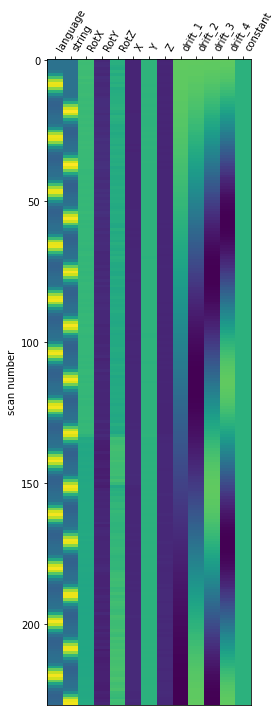

In [12]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

The first column contains the expected reponse profile of regions which are sensitive to the "Finger" task. Let's plot this first column:

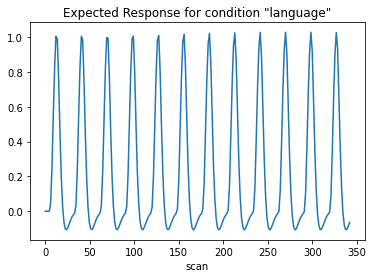

In [13]:
plt.plot(design_matrix['language'])
plt.xlabel('scan')
plt.title('Expected Response for condition "language"')
plt.show()

### Detecting voxels with significant effects

To access the estimated coefficients (Betas of the GLM model) for each condition, we
created constrast with a single '1' in each of the task columns.

In [14]:
from numpy import array
conditions = {
    'language': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'string': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
}

Let's look at it: plot the coefficients of the contrast, indexed by the names of the columns of the design matrix.

<AxesSubplot:label='conditions'>

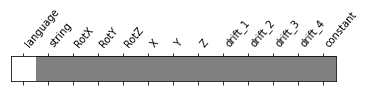

In [15]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['language'], design_matrix=design_matrix)

Below, we compute the estimated effect. It is in BOLD signal unit,
but has no statistical guarantees, because it does not take into
account the associated variance.

In [16]:
eff_map = fmri_glm.compute_contrast(conditions['language'],
                                    output_type='effect_size')

In order to get statistical significance, we form a `t-statistic`, and directly convert is into `z-scale`. The `z-scale` means that the values are scaled to match a standard Gaussian distribution (mean=`0`, variance=`1`), across voxels, if there were now effects in the data.

In [17]:
z_map = fmri_glm.compute_contrast(conditions['language'],
                                  output_type='z_score')

Plot thresholded z scores map.

We display it on top of the average functional image of the series (could be the anatomical image of the subject). We use arbitrarily a threshold of `3.0` in `z-scale`. We'll see later how to use corrected thresholds. 

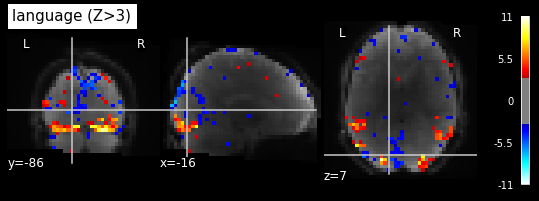

In [18]:
from nilearn.image import mean_img
mean_img = mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain

plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              #display_mode='z', cut_coords=3, 
              black_bg=True,
              title='language (Z>3)')
plt.show()

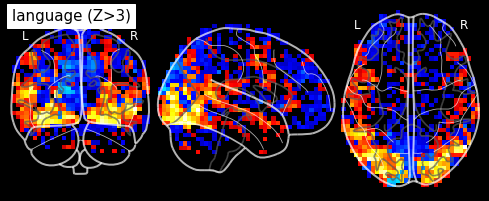

In [19]:
plot_glass_brain(z_map, threshold=3.0, black_bg=True, plot_abs=False,
                 title='language (Z>3)')
plt.show()

### Statistical signifiance testing
One should worry about the statistical validity of the procedure: here we used an arbitrary threshold of 3.0 but the threshold should provide some guarantees on the risk of false detections (aka `type-1` errors in statistics). One
first suggestion is to **control the false positive rate** (`fpr`) at a certain level, e.g. `0.001`.

Uncorrected p<0.001 threshold: 3.291


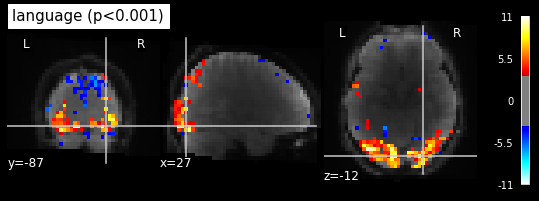

In [20]:
from nilearn.glm.thresholding import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              #display_mode='z', cut_coords=3, 
              black_bg=True,
              title='language (p<0.001)')
plt.show()

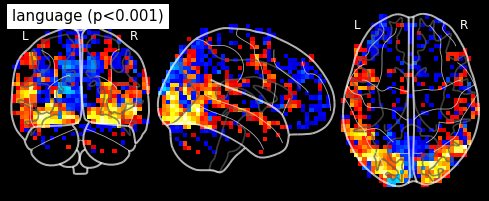

In [21]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='language (p<0.001)')
plt.show()

The example above is not corrected for **multiple comparisons**. After all, we are performing thousands of `t-tests` here (one for each voxel). A more conservative solution is to control the **family wise error** rate, i.e. the probability of making ony one false detection, say at `5%`. For that we use the so-called `Bonferroni correction`.

Bonferroni-corrected, p<0.05 threshold: 4.742


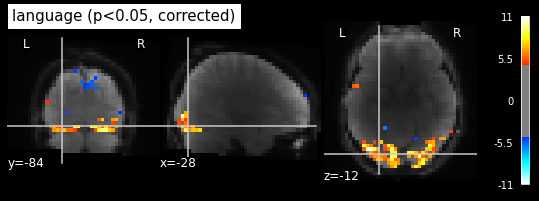

In [22]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              #display_mode='z', cut_coords=3, 
              black_bg=True,
              title='language (p<0.05, corrected)')
plt.show()

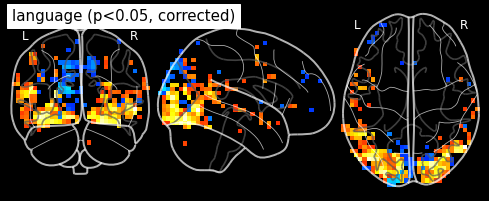

In [23]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='language (p<0.05, corrected)')
plt.show()

Finally people like to discard isolated voxels from these images. It is possible to generate a thresholded map with small clusters removed by providing a `cluster_threshold` argument. Here clusters smaller than `10` voxels will be discarded.

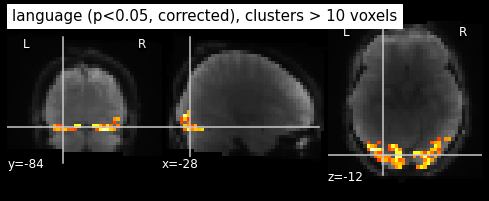

In [24]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              #display_mode='z', cut_coords=3, 
              black_bg=True, colorbar=False,
              title='language (p<0.05, corrected), clusters > 10 voxels')
plt.show()

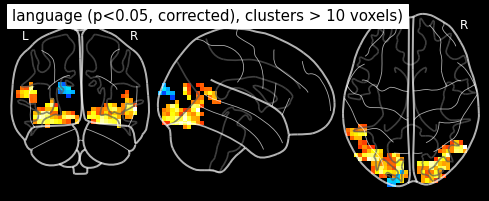

In [25]:
plot_glass_brain(clean_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='language (p<0.05, corrected), clusters > 10 voxels)')
plt.show()

### Reporting

Report the found positions in a table

In [26]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  59.5 -66.5  -4.5  10.941070               3189
1          1a  50.5 -71.0   0.0   9.364506                   
2           2 -44.0 -80.0 -13.5  10.462871              10114
3          2a -30.5 -93.5   0.0   9.666932                   
4          2b -12.5 -89.0 -13.5   9.607319                   
5          2c -12.5 -80.0 -13.5   9.256855                   
6           3  41.5 -75.5 -18.0  10.232778               6561
7          3a  23.5 -84.5 -18.0  10.028103                   
8          3b  28.0 -98.0 -13.5   8.871562                   
9          3c  10.0 -84.5 -13.5   8.534983                   
10          4 -53.0 -53.0  13.5   8.548178               2642


Using the computed `FirstLevelModel` and contrast information, we can quickly create a summary report.

In [27]:
from nilearn.reporting import make_glm_report

report = make_glm_report(fmri_glm,
                         contrasts='language',
                         bg_img=mean_img
                         )

In [28]:
report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,spm
noise_model,ar1
signal_scaling,False
slice_time_ref,0.0
smoothing_fwhm,None
standardize,False
subject_label,None


## Performing statistical analyses on BIDS datasets
Even though model specification and running was comparably easy and straightforward, it can be even better. `Nilearn`'s `GLM` functionality actually enables you to define models for multiple participants through one function by leveraging the `BIDS` standard. More precisely, the function `first_level_from_bids` takes the same input arguments as `First_Level_model` (e.g. `t_r`, `hrf_model`, `high_pass`, etc.), but through defining the `BIDS raw` and `derivatives folder`, as well as a `task` and `space` label automatically extracts all information necessary to run `individual level models` and creates the `model` itself for all participants. 

### Obtain automatically `FirstLevelModel` objects and fit arguments
From the dataset directory we automatically obtain the `FirstLevelModel` objects
with their subject_id filled from the `BIDS` dataset. Moreover, we obtain
for each model a dictionary with `run_imgs`, `events` and `confounder` regressors
since in this case a `confounds.tsv` file is available in the `BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label as specified in the file names.

In [29]:
first_level_from_bids?

Object `first_level_from_bids` not found.


In [30]:
from nilearn.glm.first_level import first_level_from_bids
task_label = 'languagelocalizer'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:949: UserWarning: SliceTimingRef not found in file /home/jovyan/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


### Quick sanity check on fit arguments

We just expect one run_img per subject.



In [31]:
import os
print([os.path.basename(run) for run in models_run_imgs[0]])

['sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz']


The only confounds stored are regressors obtained from motion correction. As
we can verify from the column headers of the confounds table corresponding
to the only run_img present.



In [32]:
print(models_confounds[0][0].columns)

Index(['RotX', 'RotY', 'RotZ', 'X', 'Y', 'Z'], dtype='object')


During this acquisition the subject read blocks of sentences and
consonant strings. So these are our only two conditions in events.
We verify there are 12 blocks for each condition.



In [33]:
print(models_events[0][0]['trial_type'].value_counts())

language    12
string      12
Name: trial_type, dtype: int64


We can also inspect the `FirstLevelModel` parameters. 

In [34]:
print(models[1])

FirstLevelModel(signal_scaling=True, subject_label='02', t_r=1.5)


### First level model estimation for all subjects
Now we simply fit each first level model and plot for each subject the
`contrast` that reveals the language network (language - string).
Notice that we can define a contrast using the names of the conditions
specified in the events dataframe.
Sum, subtraction and scalar multiplication are allowed.

Set the threshold as the `z-variate` with an uncorrected p-value of `0.001`.

In [35]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

Prepare figure for concurrent plot of individual maps.



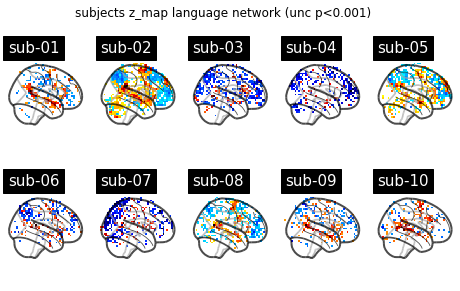

In [36]:
from nilearn import plotting
import matplotlib.pyplot as plt

models_fitted = [] 

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4.5))
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for midx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM
    model.fit(imgs, events, confounds)
    
    models_fitted.append(model)
    
    # compute the contrast of interest
    zmap = model.compute_contrast('language-string')
    plotting.plot_glass_brain(zmap, colorbar=False, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(midx / 5), int(midx % 5)],
                              plot_abs=False, display_mode='x')
fig.suptitle('subjects z_map language network (unc p<0.001)')
plotting.show()

That looks about right. However, let's also check the `design matrix`

<AxesSubplot:label='conditions', ylabel='scan number'>

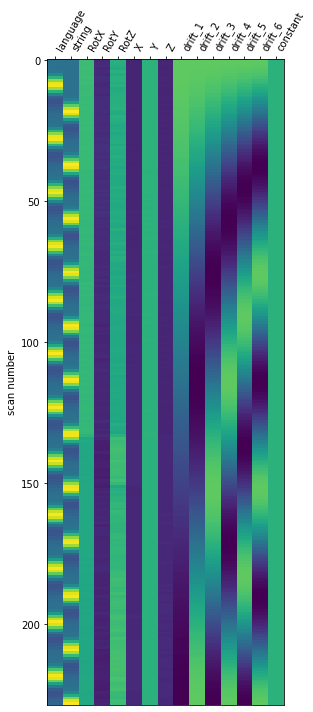

In [37]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(models_fitted[0].design_matrices_[0])

and `contrast matrix`.

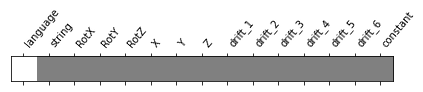

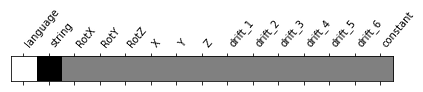

In [38]:
plot_contrast_matrix('language', models_fitted[0].design_matrices_[0])
plt.show()

plot_contrast_matrix('language - string', models_fitted[0].design_matrices_[0])
plt.show()

### Second level model estimation
We just have to provide the list of fitted `FirstLevelModel` objects
to the `SecondLevelModel` object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names).

In [39]:
from nilearn.glm.second_level import SecondLevelModel
second_level_input = models

Note that we apply a smoothing of `8mm`.



In [40]:
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a `one-sample test`
at the second level with the images determined by the specified first level
contrast.

In [41]:
zmap = second_level_model.compute_contrast(
    first_level_contrast='language-string')

The group level contrast reveals a left lateralized fronto-temporal
language network.



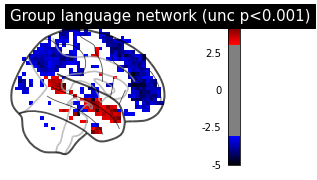

In [42]:
plotting.plot_glass_brain(zmap, colorbar=True, threshold=p001_unc,
                          title='Group language network (unc p<0.001)',
                          plot_abs=False, display_mode='x')
plotting.show()

### A summary report
And now we can create a summary report.

In [43]:
from nilearn.reporting import make_glm_report

report = make_glm_report(model=model,
                         cluster_threshold = 10,
                         contrasts='language -string',
                         display_mode = 'ortho'
                         )

/srv/conda/envs/notebook/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


In [44]:
report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,True
slice_time_ref,0.0
smoothing_fwhm,None
standardize,False
